In [7]:
# kaggle titanic
# データ分割の検証
# 特徴量の検証
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [8]:
# dataset
DATA_DIR = './data/'
TRAIN_DATA = 'train.csv'
TEST_DATA = 'test.csv'
SUBMIT_DATA = 'gender_submission.csv'

In [9]:
# load train data
RAW_DATA = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DATA))

data_test = pd.read_csv(os.path.join(DATA_DIR, TEST_DATA)) 

data = RAW_DATA

In [10]:
# fillna
data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

data.isnull().sum()

# Objective variable and Explanatory variable
y_1 = data['Survived']
# X_1 = data.drop(columns={'Survived', 'Name', 'Ticket', 'Embarked', 'Cabin'})
X_1 = data.drop(columns={'Survived', 'Name', 'Ticket', 'Cabin'})

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_1_le = X_1
Sex_le = le.fit_transform(X_1_le['Sex'])
X_1['Sex'] = Sex_le
embarked_le = le.fit_transform(X_1_le['Embarked'].values)
X_1['Embarked'] = embarked_le
X_1 = X_1.fillna(0)

In [11]:
# fillna
data_test['Fare'] = data_test['Fare'].fillna(np.mean(data_test['Fare']), inplace=True)

# Objective variable and Explanatory variable
# y_1 = data['Survived']
# data_test = data_test.drop(columns={'Name', 'Ticket', 'Embarked', 'Cabin'})
data_test = data_test.drop(columns={'Name', 'Ticket', 'Cabin'})
data_test_le = data_test
data_test_sex_le = le.fit_transform(data_test_le['Sex'])
data_test_le['Sex'] = data_test_sex_le
data_test_embarked_le = le.fit_transform(data_test_le['Embarked'])
data_test_le['Embarked'] = data_test_embarked_le
data_test_le = data_test_le.fillna(0)
data_predict = data_test_le

In [12]:
# X_train1, X_test1, y_train, y_test = train_test_split(X_1, y_1, random_state=0, test_size=0.3, stratify=y_1)
X_train1, X_test1, y_train, y_test = train_test_split(X_1, y_1, random_state=0, test_size=0.33, stratify=y_1)

In [15]:
# GridSearchCV
# パラメータを dict 型で指定
# param_grid = {"eta": [0.3, 0.5, 0.7], "colsample_bytree":[0.5, 0.8], "subsample": [0.2, 0.7], "lambda": [0, 1],
#             "learning_rate":[0.05, 0.1, 0.3, 0.5]}
param_grid = {"eta": [0.3, 0.5, 0.7], "colsample_bytree":[0.4, 0.7, 0.8], "subsample": [0.2, 0.7], "lambda": [0, 1],
             "learning_rate":[0.03, 0.05, 0.1, 0.3, 0.5], "n_estimators": [80, 100, 150]}

# validation set は GridSearchCV が自動で作成してくれるため，
# training set と test set の分割のみを実行すればよい
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train, random_state=0)

grid_search = GridSearchCV(xgb.XGBRFClassifier(), param_grid, cv=5)

# fit 関数を呼ぶことで交差検証とグリッドサーチがどちらも実行される
grid_search.fit(X_train2, y_train2)

print('Test set score: {}'.format(grid_search.score(X_test2, y_test2)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

[12:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [16]:
# GridSearchCVの結果をもとにXGBClassifierのパラーメータ指定
xgb_bst = xgb.XGBClassifier(objective="binary:logistic",
                            colsample_bytree=0.8,
                            eta=0.3,
                            # lambda= 0,
                            learning_rate=0.03,
                            subsample=0.7,
                            n_estimators=80,
                            eval_metric= 'logloss')

In [17]:
# 学習
# GridSearchCVで分割したデータを使う
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train, random_state=0)
xgb_bst.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [18]:
# xgb_bst.predict(data_predict)
xgb_bst_pred = xgb_bst.predict(data_predict)

In [19]:
# 交差検証
from sklearn.model_selection import cross_val_score

# xgbの分析結果比較
scores_01 = cross_val_score(xgb_bst ,X_train2, y_train2)
print('Cross-Validation scores: {}'.format(scores_01))

# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores_01)))

Cross-Validation scores: [0.78888889 0.81111111 0.79775281 0.78651685 0.7752809 ]
Average score: 0.7919101123595506


In [20]:
data_submit = pd.read_csv(os.path.join(DATA_DIR, SUBMIT_DATA))

In [21]:
# 提出用ファイルに予測結果を連結
# GrideSearchの結果を使った、モデリング結果を提出用ファイルに連結
data_submit['Survived'] = xgb_bst_pred

In [22]:
# write csv
data_submit.to_csv(os.path.join(DATA_DIR, 'submission_xgb14.csv'), index=False)

In [23]:
xgb_bst.score(X_train2, y_train2)

0.8881431767337807

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

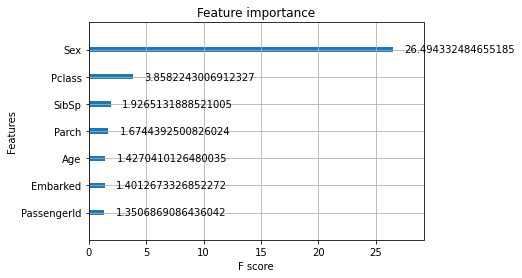

In [24]:
# feature importance
xgb.plot_importance(xgb_bst, show_values=True, importance_type='gain')